# Direct-solution ANNs and PINNs for pendulum

In [ ]:
# Code generated with: https://chatgpt.com/share/687e8e4d-d5cc-8011-9fb9-76572b71678f
# Code of original paper: https://github.com/clegaard/deep_learning_for_dynamical_systems/blob/main/

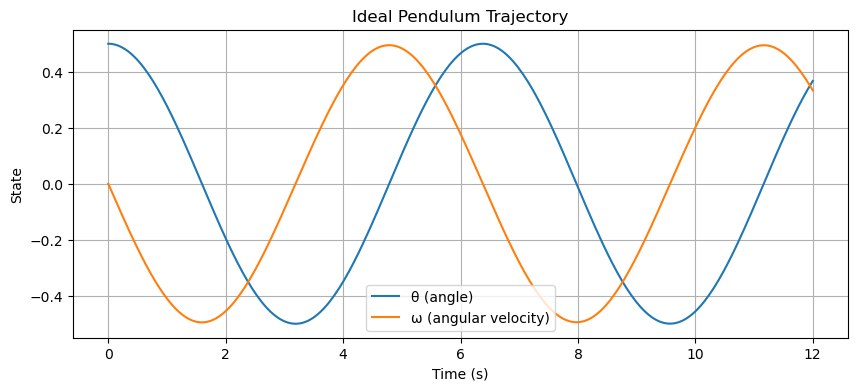

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Parameters
g = 1.0      # gravity (m/s^2)
l = 1.0       # pendulum length (m)

t_span = (0, 12)  # total simulation time
t_eval = np.linspace(*t_span, 300)  # times to evaluate

# Initial conditions: theta = 0.5 rad, omega = 0.0 rad/s
x0 = [0.5, 0.0]

# Pendulum ODE system
def pendulum_ode(t, y):
    theta, omega = y
    dtheta_dt = omega
    domega_dt = - (g / l) * np.sin(theta)
    return [dtheta_dt, domega_dt]

# Simulate trajectory
sol = solve_ivp(pendulum_ode, t_span, x0, t_eval=t_eval, method='RK45')
theta, omega = sol.y

# Plot trajectory
plt.figure(figsize=(10, 4))
plt.plot(sol.t, theta, label='θ (angle)')
plt.plot(sol.t, omega, label='ω (angular velocity)')
plt.xlabel('Time (s)')
plt.ylabel('State')
plt.title('Ideal Pendulum Trajectory')
plt.legend()
plt.grid(True)
plt.show()


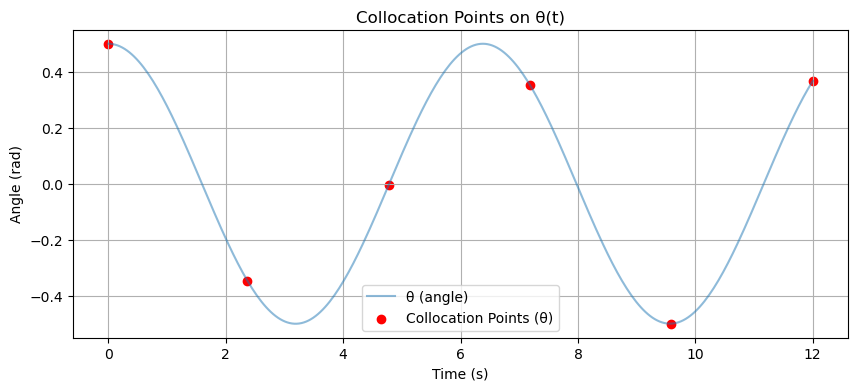

In [2]:
# Select collocation points (e.g., 30 points uniformly)
num_collocation = 6
collocation_idx = np.linspace(0, len(t_eval)-1, num_collocation, dtype=int)

t_collocation = t_eval[collocation_idx]
theta_collocation = theta[collocation_idx]
omega_collocation = omega[collocation_idx]

# Plot collocation points
plt.figure(figsize=(10, 4))
plt.plot(t_eval, theta, label='θ (angle)', alpha=0.5)
plt.scatter(t_collocation, theta_collocation, color='red', label='Collocation Points (θ)')
plt.xlabel('Time (s)')
plt.ylabel('Angle (rad)')
plt.title('Collocation Points on θ(t)')
plt.legend()
plt.grid(True)
plt.show()


In [5]:
# hyperparameters:
epochs = 10000

## Train and evaluate vanilla direct model

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim

# Prepare training data (collocation points)
t_train = torch.tensor(t_collocation, dtype=torch.float32).unsqueeze(1)  # shape (N, 1)
y_train = torch.tensor(np.vstack([theta_collocation, omega_collocation]).T, dtype=torch.float32)  # shape (N, 2)

# Define the network
class VanillaDirectNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 32),
            nn.Softplus(),
            nn.Linear(32, 32),
            nn.Softplus(),
            nn.Linear(32, 2)  # output: [theta, omega]
        )
    def forward(self, t):
        return self.net(t)

# Instantiate model, optimizer and loss
model = VanillaDirectNN()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

# Train model
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    pred = model(t_train)
    loss = loss_fn(pred, y_train)
    loss.backward()
    optimizer.step()
    if epoch % 500 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.6f}")

Epoch 0: Loss = 0.509063
Epoch 500: Loss = 0.086764
Epoch 1000: Loss = 0.049387
Epoch 1500: Loss = 0.029011
Epoch 2000: Loss = 0.000000
Epoch 2500: Loss = 0.000000
Epoch 3000: Loss = 0.000000
Epoch 3500: Loss = 0.000010
Epoch 4000: Loss = 0.000000
Epoch 4500: Loss = 0.000006
Epoch 5000: Loss = 0.000000
Epoch 5500: Loss = 0.000023
Epoch 6000: Loss = 0.000000
Epoch 6500: Loss = 0.000130
Epoch 7000: Loss = 0.000000
Epoch 7500: Loss = 0.000000
Epoch 8000: Loss = 0.000000
Epoch 8500: Loss = 0.000016
Epoch 9000: Loss = 0.000000
Epoch 9500: Loss = 0.000001


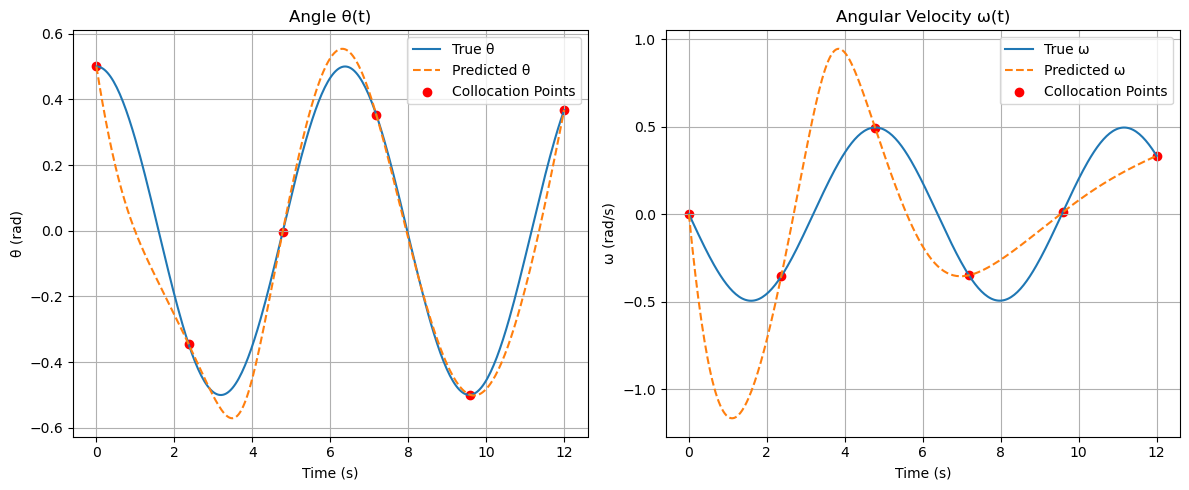

In [8]:
# Evaluate model on full time domain
model.eval()
with torch.no_grad():
    t_full = torch.tensor(t_eval, dtype=torch.float32).unsqueeze(1)
    y_pred = model(t_full).numpy()

# Extract predictions
theta_pred, omega_pred = y_pred.T
theta_direct_pred, omega_direct_pred = y_pred.T

# Plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(t_eval, theta, label='True θ')
plt.plot(t_eval, theta_pred, '--', label='Predicted θ')
plt.scatter(t_collocation, theta_collocation, c='red', label='Collocation Points')
plt.title('Angle θ(t)')
plt.xlabel('Time (s)')
plt.ylabel('θ (rad)')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(t_eval, omega, label='True ω')
plt.plot(t_eval, omega_pred, '--', label='Predicted ω')
plt.scatter(t_collocation, omega_collocation, c='red', label='Collocation Points')
plt.title('Angular Velocity ω(t)')
plt.xlabel('Time (s)')
plt.ylabel('ω (rad/s)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


## Auto-differentiation direct model

In [10]:
# Define the network: maps t → θ
class AutoDiffDirectNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 32),
            nn.Softplus(),
            nn.Linear(32, 32),
            nn.Softplus(),
            nn.Linear(32, 1)  # output: theta only
        )
    def forward(self, t):
        return self.net(t)

# Instantiate model, optimizer and loss
model_ad = AutoDiffDirectNN()
optimizer_ad = optim.Adam(model_ad.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()


In [11]:
# Enable gradient tracking for t
t_train_ad = t_train.clone().detach().requires_grad_(True)
theta_true = torch.tensor(theta_collocation, dtype=torch.float32).unsqueeze(1)
omega_true = torch.tensor(omega_collocation, dtype=torch.float32).unsqueeze(1)

# Training
for epoch in range(epochs):
    model_ad.train()
    optimizer_ad.zero_grad()

    # Predict θ
    theta_pred = model_ad(t_train_ad)

    # Compute ω = dθ/dt using autograd
    omega_pred = torch.autograd.grad(
        theta_pred, t_train_ad,
        grad_outputs=torch.ones_like(theta_pred),
        create_graph=True
    )[0]

    # Compute combined loss
    loss_theta = loss_fn(theta_pred, theta_true)
    loss_omega = loss_fn(omega_pred, omega_true)
    loss = loss_theta + loss_omega

    loss.backward()
    optimizer_ad.step()

    if epoch % 500 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.6f}")


Epoch 0: Loss = 1.586524
Epoch 500: Loss = 0.205202
Epoch 1000: Loss = 0.184695
Epoch 1500: Loss = 0.104301
Epoch 2000: Loss = 0.009962
Epoch 2500: Loss = 0.007632
Epoch 3000: Loss = 0.005437
Epoch 3500: Loss = 0.003786
Epoch 4000: Loss = 0.003207
Epoch 4500: Loss = 0.002933
Epoch 5000: Loss = 0.002699
Epoch 5500: Loss = 0.002455
Epoch 6000: Loss = 0.002200
Epoch 6500: Loss = 0.003709
Epoch 7000: Loss = 0.001684
Epoch 7500: Loss = 0.001500
Epoch 8000: Loss = 0.001189
Epoch 8500: Loss = 0.001110
Epoch 9000: Loss = 0.000757
Epoch 9500: Loss = 0.000476


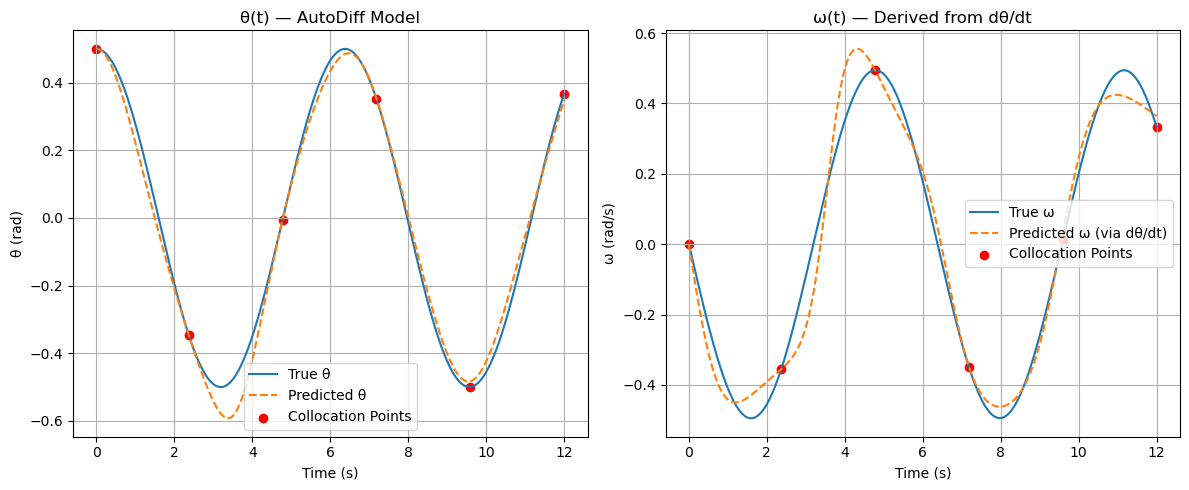

In [12]:
# Evaluate on full time domain
t_full_ad = torch.tensor(t_eval, dtype=torch.float32).unsqueeze(1).requires_grad_(True)

with torch.no_grad():
    theta_full_pred = model_ad(t_full_ad)

# Re-enable gradients for ω computation
theta_full_pred = model_ad(t_full_ad)
omega_full_pred = torch.autograd.grad(
    theta_full_pred, t_full_ad,
    grad_outputs=torch.ones_like(theta_full_pred),
    create_graph=False
)[0]

# Convert to NumPy
theta_pred_ad = theta_full_pred.detach().numpy().flatten()
omega_pred_ad = omega_full_pred.detach().numpy().flatten()

# Plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(t_eval, theta, label='True θ')
plt.plot(t_eval, theta_pred_ad, '--', label='Predicted θ')
plt.scatter(t_collocation, theta_collocation, c='red', label='Collocation Points')
plt.title('θ(t) — AutoDiff Model')
plt.xlabel('Time (s)')
plt.ylabel('θ (rad)')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(t_eval, omega, label='True ω')
plt.plot(t_eval, omega_pred_ad, '--', label='Predicted ω (via dθ/dt)')
plt.scatter(t_collocation, omega_collocation, c='red', label='Collocation Points')
plt.title('ω(t) — Derived from dθ/dt')
plt.xlabel('Time (s)')
plt.ylabel('ω (rad/s)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## PINN

In [18]:
# Reuse previous network that outputs only θ
class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 32),
            nn.Softplus(),
            nn.Linear(32, 32),
            nn.Softplus(),
            nn.Linear(32, 1)
        )
    def forward(self, t):
        return self.net(t)

model_pinn = PINN()
optimizer_pinn = optim.Adam(model_pinn.parameters(), lr=1e-3)


In [20]:
# Inputs for training with gradients
t_train_pinn = t_train.clone().detach().requires_grad_(True)

# Ground-truth values at collocation points
theta_true = torch.tensor(theta_collocation, dtype=torch.float32).unsqueeze(1)
omega_true = torch.tensor(omega_collocation, dtype=torch.float32).unsqueeze(1)

In [ ]:
for epoch in range(epochs):
    model_pinn.train()
    optimizer_pinn.zero_grad()

    # Predict θ
    theta_pred = model_pinn(t_train_pinn)

    # ω = dθ/dt
    omega_pred = torch.autograd.grad(
        theta_pred, t_train_pinn,
        grad_outputs=torch.ones_like(theta_pred),
        create_graph=True
    )[0]

    # dω/dt = d²θ/dt²
    domega_dt = torch.autograd.grad(
        omega_pred, t_train_pinn,
        grad_outputs=torch.ones_like(omega_pred),
        create_graph=True
    )[0]

    # Physics-informed residual: dω/dt + (g/l) * sin(θ) = 0
    physics_residual = domega_dt + (g / l) * torch.sin(theta_pred)

    # Loss terms
    loss_collocation = loss_fn(theta_pred, theta_true) + loss_fn(omega_pred, omega_true)
    loss_physics = loss_fn(physics_residual, torch.zeros_like(physics_residual))

    # Total loss
    loss = loss_collocation + loss_physics

    loss.backward()
    optimizer_pinn.step()

    if epoch % 500 == 0:
        print(f"Epoch {epoch}: Total Loss = {loss.item():.6f} | Data = {loss_collocation.item():.6f} | Physics = {loss_physics.item():.6f}")


Epoch 0: Total Loss = 0.277418 | Data = 0.253953 | Physics = 0.023465
Epoch 500: Total Loss = 0.144393 | Data = 0.135236 | Physics = 0.009157
Epoch 1000: Total Loss = 0.028060 | Data = 0.020072 | Physics = 0.007988
Epoch 1500: Total Loss = 0.017813 | Data = 0.009099 | Physics = 0.008714


In [ ]:
# Evaluation over full time domain
t_full = torch.tensor(t_eval, dtype=torch.float32).unsqueeze(1).requires_grad_(True)
theta_pred_full = model_pinn(t_full)

# ω = dθ/dt
omega_pred_full = torch.autograd.grad(
    theta_pred_full, t_full,
    grad_outputs=torch.ones_like(theta_pred_full),
    create_graph=False
)[0]

theta_pinn = theta_pred_full.detach().numpy().flatten()
omega_pinn = omega_pred_full.detach().numpy().flatten()

theta_pinn_pred = theta_pinn
omega_pinn_pred = omega_pinn

# Plot results
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(t_eval, theta, label='True θ')
plt.plot(t_eval, theta_pinn, '--', label='PINN Predicted θ')
plt.scatter(t_collocation, theta_collocation, c='red', label='Collocation Points')
plt.title('θ(t) — PINN')
plt.xlabel('Time (s)')
plt.ylabel('θ (rad)')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(t_eval, omega, label='True ω')
plt.plot(t_eval, omega_pinn, '--', label='PINN Predicted ω')
plt.scatter(t_collocation, omega_collocation, c='red', label='Collocation Points')
plt.title('ω(t) — PINN')
plt.xlabel('Time (s)')
plt.ylabel('ω (rad/s)')
plt.legend()
plt.grid(True)

plt.tight_layout()

from google.colab import files
# Save the 3x2 plot to a file in the current directory
fig.savefig("pinns_comparison_plot.png", dpi=300, bbox_inches='tight')
files.download("pinns_comparison_plot.png")

plt.show()


## Plot for article

In [ ]:
theta_true = theta
omega_true = omega

In [ ]:
phi_true = theta
dot_phi_true = omega

phi_collocation = theta_collocation
dot_phi_collocation = omega_collocation

phi_direct_pred = theta_direct_pred
dot_phi_direct_pred = omega_direct_pred

phi_pinn_pred = theta_pinn_pred
dot_phi_pinn_pred = omega_pinn_pred

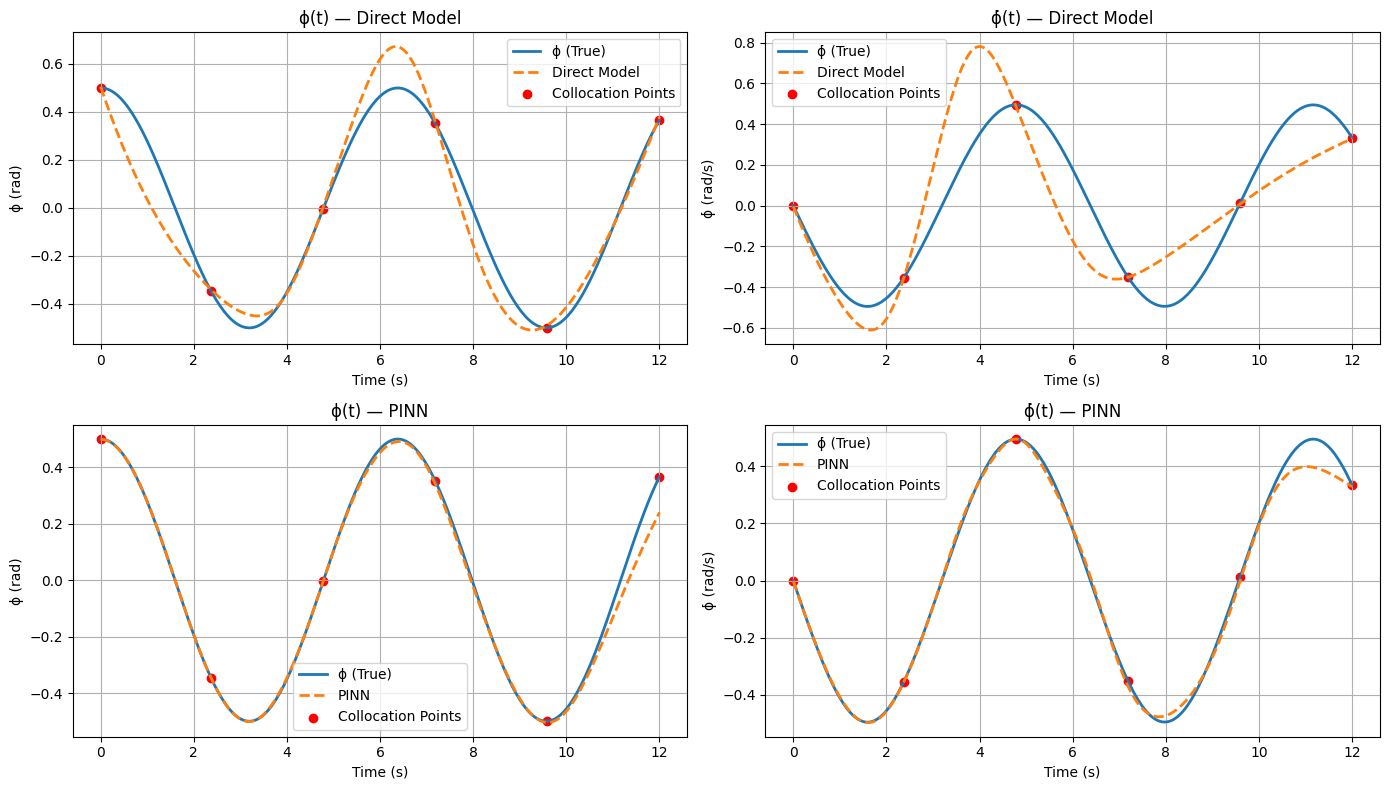

In [ ]:
# Ensure all collocation arrays are 1D for plotting
phi_collocation = phi_collocation.flatten()
dot_phi_collocation = dot_phi_collocation.flatten()

# Plot only Direct model and PINN model
fig, axs = plt.subplots(2, 2, figsize=(14, 8))

# --- Row 1 (was Row 2): Direct model ---
axs[0, 0].plot(t_eval, phi_true, label='ϕ (True)', linewidth=2)
axs[0, 0].plot(t_eval, phi_direct_pred, '--', label='Direct Model', linewidth=2)
axs[0, 0].scatter(t_collocation, phi_collocation, c='red', label='Collocation Points')
axs[0, 0].set_title('ϕ(t) — Direct Model')
axs[0, 0].set_xlabel('Time (s)')
axs[0, 0].set_ylabel('ϕ (rad)')
axs[0, 0].legend()
axs[0, 0].grid(True)

axs[0, 1].plot(t_eval, dot_phi_true, label='ϕ̇ (True)', linewidth=2)
axs[0, 1].plot(t_eval, dot_phi_direct_pred, '--', label='Direct Model', linewidth=2)
axs[0, 1].scatter(t_collocation, dot_phi_collocation, c='red', label='Collocation Points')
axs[0, 1].set_title('ϕ̇(t) — Direct Model')
axs[0, 1].set_xlabel('Time (s)')
axs[0, 1].set_ylabel('ϕ̇ (rad/s)')
axs[0, 1].legend()
axs[0, 1].grid(True)

# --- Row 2 (was Row 3): PINN model ---
axs[1, 0].plot(t_eval, phi_true, label='ϕ (True)', linewidth=2)
axs[1, 0].plot(t_eval, phi_pinn_pred, '--', label='PINN', linewidth=2)
axs[1, 0].scatter(t_collocation, phi_collocation, c='red', label='Collocation Points')
axs[1, 0].set_title('ϕ(t) — PINN')
axs[1, 0].set_xlabel('Time (s)')
axs[1, 0].set_ylabel('ϕ (rad)')
axs[1, 0].legend()
axs[1, 0].grid(True)

axs[1, 1].plot(t_eval, dot_phi_true, label='ϕ̇ (True)', linewidth=2)
axs[1, 1].plot(t_eval, dot_phi_pinn_pred, '--', label='PINN', linewidth=2)
axs[1, 1].scatter(t_collocation, dot_phi_collocation, c='red', label='Collocation Points')
axs[1, 1].set_title('ϕ̇(t) — PINN')
axs[1, 1].set_xlabel('Time (s)')
axs[1, 1].set_ylabel('ϕ̇ (rad/s)')
axs[1, 1].legend()
axs[1, 1].grid(True)

# Adjust vertical spacing between rows
plt.subplots_adjust(hspace=0.4)  # You can increase this value for more spacing

plt.tight_layout()
plt.show()
